In [ ]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

## Context Isolation: Sub-agents

Agent context can grow quickly as conversations progress, leading to several long context-related problems. A primary issue is context clash or confusion, where mixed objectives within the same context window can lead to suboptimal performance. [Context isolation](https://blog.langchain.com/context-engineering-for-agents/) provides an effective solution by delegating tasks to [specialized sub-agents](https://www.anthropic.com/engineering/multi-agent-research-system), each operating within their own isolated context window. This approach prevents context clashes, confusion, poisoning, and dilution while enabling focused, specialized task execution.

### Sub-agent delegation

The primary insight is that we can create sub-agents with different tool sets tailored to specific tasks. Each sub-agent is stored in a registry dictionary with `subagent_type` as the key, allowing the main agent to delegate work through a `task(description, subagent_type)` tool call. The sub-agent operates in complete isolation from the parent's context, and its results are returned as a `ToolMessage` to the parent agent, maintaining clean separation of concerns.

**TODO(Geoff)** Can see if we need any preamble text here. 

In [ ]:
%%writefile ../src/deep_agents_from_scratch/task_tool.py

from typing import Annotated, NotRequired, TypedDict

from langchain_core.messages import ToolMessage
from langchain_core.tools import BaseTool, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.types import Command

from deep_agents_from_scratch.prompts import TASK_DESCRIPTION_PREFIX
from deep_agents_from_scratch.state import DeepAgentState


class SubAgent(TypedDict):
    """Configuration for a specialized sub-agent."""
    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]

def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.

    This function implements the core pattern for spawning specialized sub-agents with
    isolated contexts, preventing context clash and confusion in complex multi-step tasks.

    Args:
        tools: List of available tools that can be assigned to sub-agents
        subagents: List of specialized sub-agent configurations
        model: The language model to use for all agents
        state_schema: The state schema (typically DeepAgentState)

    Returns:
        A 'task' tool that can delegate work to specialized sub-agents
    """
    # Create agent registry
    agents = {}

    # Build tool name mapping for selective tool assignment
    tools_by_name = {}
    for tool_ in tools:
        if not isinstance(tool_, BaseTool):
            tool_ = tool(tool_)
        tools_by_name[tool_.name] = tool_

    # Create specialized sub-agents based on configurations
    for _agent in subagents:
        if "tools" in _agent:
            # Use specific tools if specified
            _tools = [tools_by_name[t] for t in _agent["tools"]]
        else:
            # Default to all tools
            _tools = tools
        agents[_agent["name"]] = create_react_agent(
            model, prompt=_agent["prompt"], tools=_tools, state_schema=state_schema
        )

    # Generate description of available sub-agents for the tool description
    other_agents_string = [
        f"- {_agent['name']}: {_agent['description']}" for _agent in subagents
    ]

    @tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
    def task(
        description: str,
        subagent_type: str,
        state: Annotated[DeepAgentState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Delegate a task to a specialized sub-agent with isolated context.

        This creates a fresh context for the sub-agent containing only the task description,
        preventing context pollution from the parent agent's conversation history.
        """
        # Validate requested agent type exists
        if subagent_type not in agents:
            return f"Error: invoked agent of type {subagent_type}, the only allowed types are {[f'`{k}`' for k in agents]}"

        # Get the requested sub-agent
        sub_agent = agents[subagent_type]

        # Create isolated context with only the task description
        # This is the key to context isolation - no parent history
        state["messages"] = [{"role": "user", "content": description}]

        # Execute the sub-agent in isolation
        result = sub_agent.invoke(state)

        # Return results to parent agent via Command state update
        return Command(
            update={
                "files": result.get("files", {}),  # Merge any file changes
                "messages": [
                    # Sub-agent result becomes a ToolMessage in parent context
                    ToolMessage(
                        result["messages"][-1].content, tool_call_id=tool_call_id
                    )
                ],
            }
        )

    return task

Now, we can define specific sub-agents and allow the system to call them with the `task` tool.

### Prompting Strategy

The prompting strategy for sub-agents follows several key principles:

1. **Specialized Instructions**: Each sub-agent receives tailored system prompts that focus on their specific domain (e.g., research, analysis, coding)
2. **Context Isolation**: Sub-agents start with a clean context containing only the delegated task description, preventing contamination from parent agent conversations
3. **Tool Restriction**: Sub-agents are given only the tools necessary for their specialized function, reducing complexity and improving focus
4. **Clear Boundaries**: The parent agent delegates discrete, well-scoped tasks rather than open-ended objectives to maintain clarity

This approach ensures that each sub-agent operates as a focused specialist rather than a generalist, leading to better performance on specific tasks while maintaining overall system coherence.

In [5]:
from utils import show_prompt

from deep_agents_from_scratch.prompts import SUBAGENT_USAGE_INSTRUCTIONS

show_prompt(SUBAGENT_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your role is to coordinate research by delegating specific research tasks to sub-agents.                       │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  1. **task(description, subagent_type)**: Delegate research tasks to specialized sub-agents                     │
│     - description: Clear, specific research question or task                                                    │
│     - subagent_type: Type of agent to use (e.g., "research-agent")                                              │
│  2. **think_tool(reflection)**: Reflect on the results of each delegated task and plan next steps.              │
│     - reflection: Your detailed reflection on the results of the task and next steps.                           │
│                                                                                                                 │
│  **PARALLEL RESEARCH**: When you identify multiple independent research directions, make multiple **task**      │
│  tool calls in a single response to enable parallel execution. Use at most {max_concurrent_research_units}      │
│  parallel agents per iteration.                                                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Task Delegation Budgets** (Prevent excessive delegation):                                                    │
│  - **Bias towards focused research** - Use single agent for simple questions, multiple only when clearly        │
│  beneficial or when you have multiple independent research directions based on the user's request.              │
│  - **Stop when adequate** - Don't over-research; stop when you have sufficient information                      │
│  - **Limit iterations** - Stop after {max_researcher_iterations} task delegations if you haven't found          │
│  adequate sources                                                                                               │
│  </Hard Limits>                                                                                                 │
│                                                                                                                 │
│  <Scaling Rules>                                                                                                │
│  **Simple fact-finding, lists, and rankings** can use a single sub-agent:                                       │
│  - *Example*: "List the top 10 coffee shops in San Francisco" → Use 1 sub-agent, store in                       │
│  `findings_coffee_shops.md`                                                                                     │
│                                                                                                                 │
│  **Comparisons** can use a sub-agent for each element 

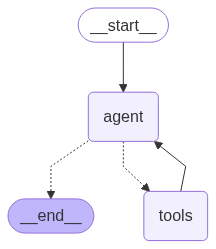

In [8]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent

from deep_agents_from_scratch.prompts import (
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool

# Limits 
max_concurrent_research_units = 3 
max_researcher_iterations = 3

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS,
    "tools": ["tavily_search", "think_tool"] 
}

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)

# Tools for sub-agent
sub_agent_tools = [tavily_search, think_tool]

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools,
    [research_sub_agent],
    model,
    DeepAgentState
)

# Tools 
delegation_tools = [task_tool] 
built_in_tools = [think_tool]

# Create agent with system prompt
agent = create_react_agent(
    model, 
    delegation_tools + built_in_tools, 
    prompt=SUBAGENT_USAGE_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
        date=datetime.now().strftime("%a %b %-d, %Y") 
    ), 
    state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [9]:
from utils import format_messages

result = agent.invoke({
    "messages": [{"role": "user", "content": "Give me an overview of Model Context Protocol (MCP)."}],
})

format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll research the Model Context Protocol (MCP) to provide you with a comprehensive overview.                    │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research the Model Context Protocol (MCP) and provide a comprehensive overview including:     │
│ what it is, its purpose and goals, key features and capabilities, how it works technically, who developed it,   │
│ current adoption status, and any notable implementations or use cases",                                         │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_0179t9cFeDtALeptePRfNnCn                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## What is the Model Context Protocol (MCP)?                                                                    │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an open standard developed by Anthropic that facilitates standardized       │
│ communication between AI systems (particularly Large Language Models) and various external data sources and     │
│ tools. It serves as a universal interface that enables AI models to securely access and interact with external  │
│ resources in a modular, standardized way.                                                                       │
│                                                                                                                 │
│ ## Purpose and Goals                                                                                            │
│                                                                                                                 │
│ MCP was designed to address several key challenges in AI system integration:                                    │
│                                                                                                                 │
│ - **Resolve Information Silos**: Break down barriers between AI systems and external data sources               │
│ - **Standardize Data Integration**: Provide a universal interface for AI-external tool communication            │
│ - **Enable Secure Connections**: Facilitate secure, bidirectional communication between AI systems and external │
│ resources                                                                                                       │
│ - **Streamline Integration**: Eliminate the need for hard-coded integrations and custom solutions               │
│ - **Enhance Modularity**: Allow organizations to adapt and manage their AI systems more efficiently             │
│                                                                                                                 │
│ ## Key Features and Capabilities                                                                                │
│                                                                                                                 │
│ - **Universal Interface**: Provides standardized methods for reading files and executing functions              │
│ - **Modular Architecture**: Enables plug-and-play integration without hard-coded connections                    │
│ - **Security and Compliance**: Built-in security features to ensure safe data access and tool execution         │
│ - **Bidirectional Communication**: Supports two-way data flow between AI systems and external tools             │
│ - **Cross-Platform Compatibility**: Works across various AI systems and external data sources                   │
│                                                                                                                 │
│ ## Technical Architecture                                                                                       │
│                                                                                                                 │
│ MCP operates on a **client-server model** consisting of three main components:                                  │
│                                                                                                                 │
│ 1. **Hosts**: The AI applications or systems that need to access external resources                             │
│ 2. **Clients**: Interface components that manage commun

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research agent provided a comprehensive overview of the Model Context Protocol (MCP) that  │
│ covers all the key aspects I was looking for:\n\n1. **Definition and Purpose**: Clear explanation of what MCP   │
│ is and why it was created\n2. **Technical Details**: Good coverage of the client-server architecture and key    │
│ components\n3. **Developer Information**: Anthropic as the creator, launched in November 2024\n4. **Adoption    │
│ Status**: Information about current adoption by major AI companies\n5. **Use Cases**: Concrete examples of      │
│ implementations and applications\n6. **Future Outlook**: Assessment of the protocol's potential impact\n\nThe   │
│ information appears comprehensive and well-structured. The agent covered the technical architecture, practical  │
│ applications, and current status effectively. I have sufficient information to provide a complete overview to   │
│ the user without needing additional research.\n\nThe response includes specific details about:\n- The           │
│ three-component architecture (hosts, clients, servers)\n- Notable implementations (AWS, GitHub, Google          │
│ services)\n- Use cases across different domains (software development, enterprise, research)\n- Timeline and    │
│ adoption status\n\nThis gives me a solid foundation to present a thorough overview of MCP to the user."         │
│ }                                                                                                               │
│    ID: toolu_01KdcfRZg7WhRZb6mPW6RskV                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research agent provided a comprehensive overview of the Model Context Protocol (MCP)   │
│ that covers all the key aspects I was looking for:                                                              │
│                                                                                                                 │
│ 1. **Definition and Purpose**: Clear explanation of what MCP is and why it was created                          │
│ 2. **Technical Details**: Good coverage of the client-server architecture and key components                    │
│ 3. **Developer Information**: Anthropic as the creator, launched in November 2024                               │
│ 4. **Adoption Status**: Information about current adoption by major AI companies                                │
│ 5. **Use Cases**: Concrete examples of implementations and applications                                         │
│ 6. **Future Outlook**: Assessment of the protocol's potential impact                                            │
│                                                                                                                 │
│ The information appears comprehensive and well-structured. The agent covered the technical architecture,        │
│ practical applications, and current status effectively. I have sufficient information to provide a complete     │
│ overview to the user without needing additional research.                                                       │
│                                                                                                                 │
│ The response includes specific details about:                                                                   │
│ - The three-component architecture (hosts, clients, servers)                                                    │
│ - Notable implementations (AWS, GitHub, Google services)                                                        │
│ - Use cases across different domains (software development, enterprise, research)                               │
│ - Timeline and adoption status                                                                                  │
│                                                                                                                 │
│ This gives me a solid foundation to present a thorough overview of MCP to the user.                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP) Overview                                                                         │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open standard developed by Anthropic in November 2024 that enables   │
│ standardized communication between AI systems (particularly Large Language Models) and external data sources    │
│ and tools. Think of it as a universal interface that allows AI models to securely access and interact with      │
│ external resources in a modular, plug-and-play fashion.                                                         │
│                                                                                                                 │
│ ## Why Was MCP Created?                                                                                         │
│                                                                                                                 │
│ MCP addresses several critical challenges in AI system integration:                                             │
│                                                                                                                 │
│ - **Breaking Down Information Silos**: Eliminates barriers between AI systems and external data                 │
│ - **Standardizing Integration**: Provides a universal interface instead of custom, hard-coded solutions         │
│ - **Enabling Secure Access**: Facilitates safe, bidirectional communication with external resources             │
│ - **Enhancing Modularity**: Allows organizations to adapt their AI systems more efficiently                     │
│                                                                                                                 │
│ ## Technical Architecture                                                                                       │
│                                                                                                                 │
│ MCP uses a **client-server model** with three main components:                                                  │
│                                                                                                                 │
│ 1. **Hosts**: AI applications that need external resource access                                                │
│ 2. **Clients**: Interface components managing communication between hosts and servers                           │
│ 3. **Servers**: External services or data sources providing tools and information                               │
│                                                                                                                 │
│ This architecture promotes standardized communication while maintaining flexibility and avoiding hard-coded     │
│ integrations.                                                                                                   │
│                                                                                                                 │
│ ## Key Features                                                                                                 │
│                                                                                                                 │
│ - **Universal Interface**: Standardized methods for file reading and function execution                         │
│ - **Modular Design**: Plug-and-play integration capabilities                                                    │
│ - **Security Built-in**: Secure data access and tool ex

Trace: 

https://smith.langchain.com/public/d96352bc-d399-416c-9afb-4d8aa58e126c/r